In [1]:
%matplotlib inline

import pandas as pd
import pylab as plt
import numpy as np
import scipy as sc
import scipy.stats
import math

# Modeling

In this notebook, we will try to build a model for predicting yield in the Univeristy of California system. We will try to achieve the goal by:
 - predicting the yield for each high school
 - combining the predicted yields into a single yield for all high schools
 
In other words, we will try to predict the `yield` column given other columns (besides the data about enrolled students).

## Loading the data

### Incorporating the New Dataset

First, we will load our data. Our dataset contains some extra columns for schools in California:
 - AP scores
 - SAT scores
 - Senior class enrollment
 - Distances to UC campuses
 
That is why we will only perform our modelling in the state of California. Moreover, since our ethnicty data is very erratic, we will only use the cumulative data (`data['ethnicity'] == 'All'`).

In [2]:
data = pd.read_csv("data/with_scores.csv")
data = data[data['state']=='California']
data = data[data['campus'] != 'Universitywide']
data = data[data['ethnicity'] == 'All']

## Choosing the features

The overall plan is to select the newly added features i.e. various test scores, combining with our old features, and generate a linear regression model to make predictions.

First of all, we should take a look of the new dataset. We have a large number of NaNs in the test-score fields, so we might need to drop them if needed. 

In [3]:
data.columns

Index(['campus', 'year', 'school', 'school_num', 'city', 'county', 'state',
       'country', 'region', 'ethnicity', 'app_num', 'adm_num', 'enr_num',
       'app_gpa', 'adm_gpa', 'enr_gpa', 'distance', 'ap_num_scr1',
       'ap_num_scr2', 'ap_num_scr3', 'ap_num_scr4', 'ap_num_scr5',
       'ap_num_test_takers', 'enroll12', 'school_name', 'sat_math_avg',
       'sat_num_test_takers', 'sat_total_avg', 'sat_verbal_avg', 'yield'],
      dtype='object')

check how many NaN's are there in each field 

In [4]:
count_nan = len(data) - data.count()
count_nan

campus                     0
year                       0
school                     0
school_num             24423
city                       0
county                     0
state                      0
country                    0
region                     0
ethnicity                  0
app_num                    0
adm_num                25145
enr_num                69450
app_gpa                    0
adm_gpa                25145
enr_gpa                69450
distance                  23
ap_num_scr1            42130
ap_num_scr2            42133
ap_num_scr3            42135
ap_num_scr4            42151
ap_num_scr5            42212
ap_num_test_takers     40769
enroll12               40229
school_name            40229
sat_math_avg           41000
sat_num_test_takers    40739
sat_total_avg          41000
sat_verbal_avg         41000
yield                  69450
dtype: int64

After careful consideration we decided to use the features in `train_cols` below for training. Some of the factors we considered:

- We should not include all of `sat_total_avg`, `sat_math_avg`, `sat_verbal_avg` - since each is a linear combination of the other two.
- We must not use the `enr_*` fields since that would cause bleeding of the predicted column into the training set. Moreover, no enrollment data will be available at the time of the prediction - modelling yield is only interesting if we don't know who accepted the admission offer.

In [5]:
train_cols = [
    'year', 
    'app_num', 'adm_num', 
    'app_gpa', 'adm_gpa',
    'distance',
    'ap_num_scr1', 'ap_num_scr2', 'ap_num_scr3', 'ap_num_scr4', 'ap_num_scr5',
    'ap_num_test_takers',
    'enroll12',
    'sat_total_avg', 'sat_num_test_takers'
]
pred_col = ['yield']

def get_data_for_campus(df, campus_name):
     return df[df['campus'] == campus_name].dropna()
    

Next, we will inspect example training and testing data.

In [6]:
berkeley_data = get_data_for_campus(data, 'Berkeley')
berkeley_data[train_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
year,1533.0,2006.438356,5.123120,1998.000000,2002.000000,2006.000000,2011.000000,2015.000000
app_num,1533.0,76.707110,46.185257,11.000000,43.000000,68.000000,97.000000,308.000000
adm_num,1533.0,19.054142,11.516321,5.000000,11.000000,16.000000,24.000000,86.000000
app_gpa,1533.0,3.849583,0.117607,3.271579,3.774948,3.855942,3.932885,4.112941
adm_gpa,1533.0,4.162445,0.096072,3.495000,4.116304,4.181429,4.229286,4.362500
distance,1533.0,358743.354207,292128.519051,662.000000,51515.000000,302470.000000,634670.000000,958441.000000
ap_num_scr1,1533.0,83.444879,73.315471,0.000000,34.000000,62.000000,113.000000,581.000000
ap_num_scr2,1533.0,140.981083,85.277999,0.000000,80.000000,127.000000,183.000000,571.000000
ap_num_scr3,1533.0,203.210046,126.119971,0.000000,105.000000,181.000000,279.000000,732.000000
ap_num_scr4,1533.0,189.658187,140.994974,0.000000,82.000000,158.000000,268.000000,796.000000


In [7]:
berkeley_data[pred_col].describe()

,yield
count,1533.000000
mean,0.552133
std,0.173931
min,0.178571
25%,0.428571
50%,0.529412
75%,0.666667
max,1.000000


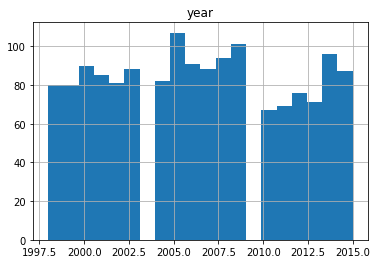

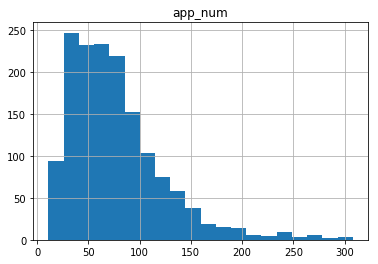

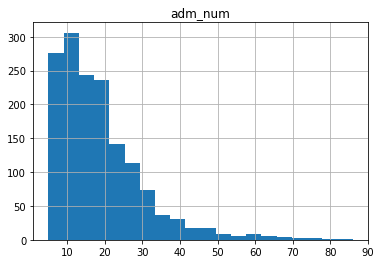

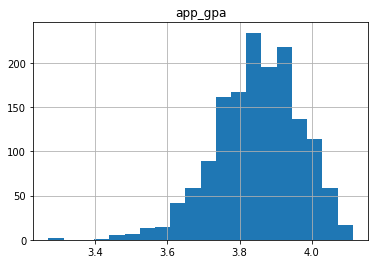

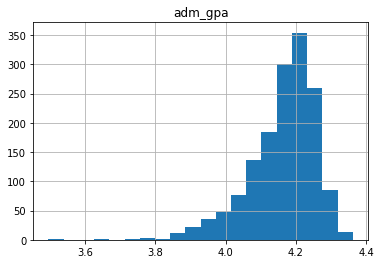

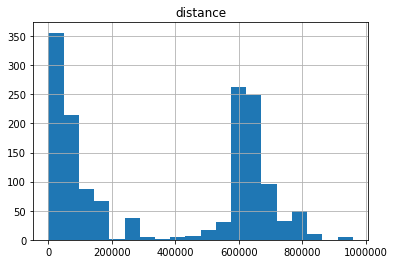

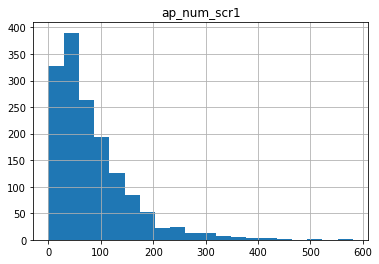

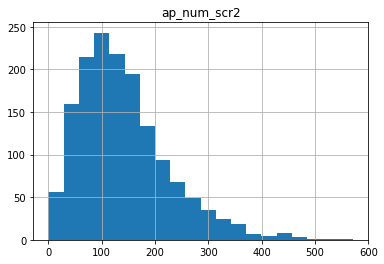

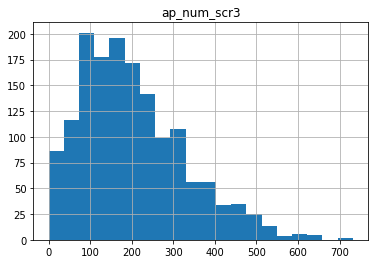

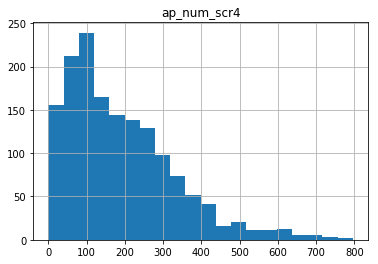

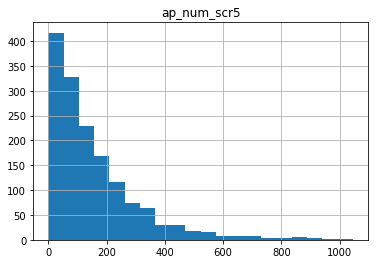

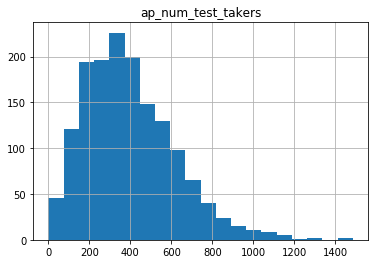

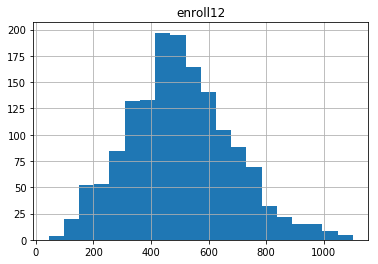

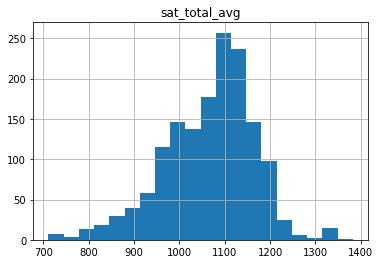

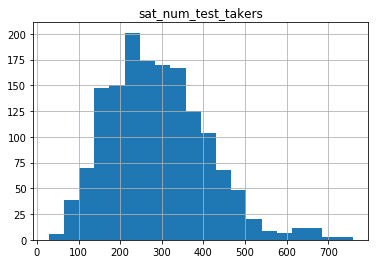

In [8]:
for col in train_cols:
    plt.figure()
    plt.title(col)
    berkeley_data[col].hist(bins=20)

## Using Z-scores in our model

To make sure all of our data is on the same scale, we will prepare Z-Scoring functions. However, our predictions will then be outputed on the Z-Score scale, thus we will also need a function to undo the Z-Scores.

In [9]:
def z_score(X):
    return (X-X.mean(axis=0)) / X.std(axis=0)

def z_score_from_different_data_sample(X, diff_sample):
    return (X-diff_sample.mean(axis=0)) / diff_sample.std(axis=0)

def undo_z_score(to_undo, orig_sample):
    return (to_undo * orig_sample.std(axis=0)) + orig_sample.mean(axis=0)

We will now see the distribution of our data when Z-scored (shown on the data from UC Berkeley)

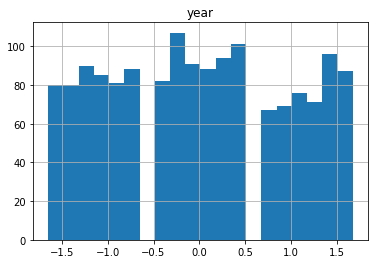

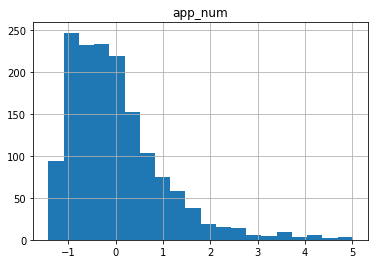

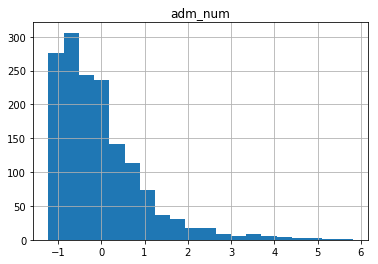

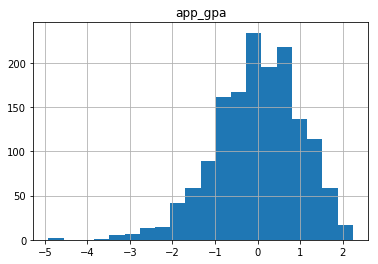

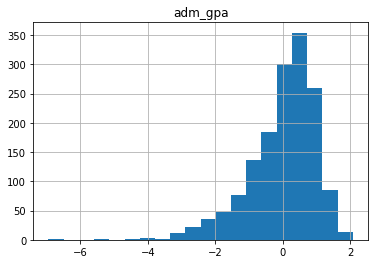

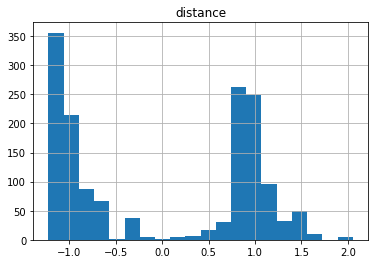

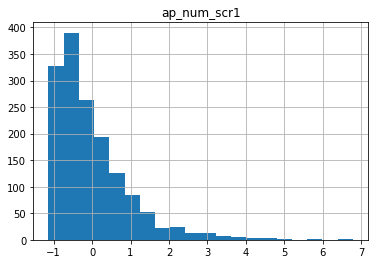

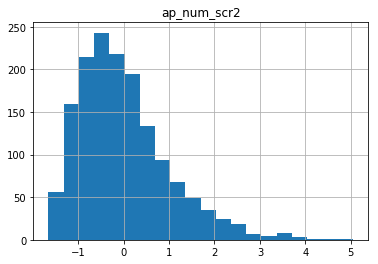

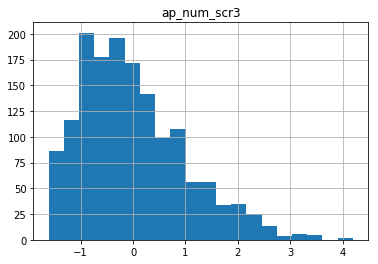

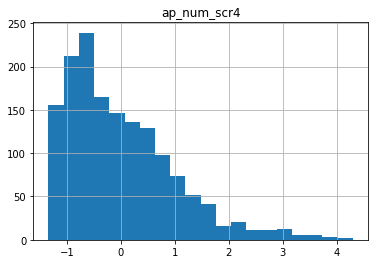

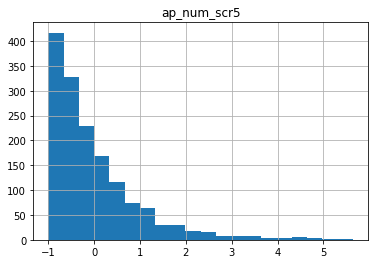

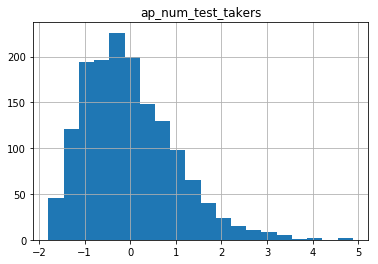

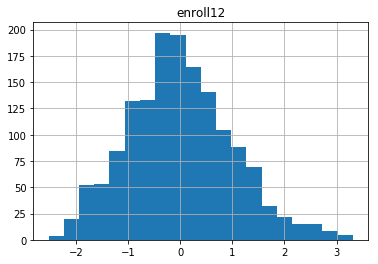

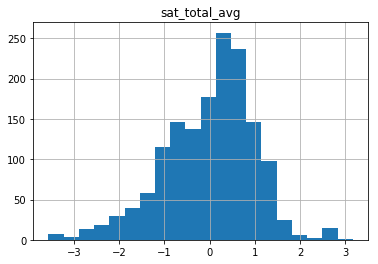

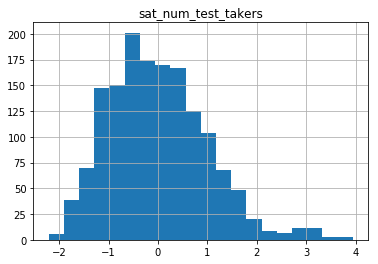

In [10]:
for col in train_cols:
    plt.figure()
    plt.title(col)
    z_score(berkeley_data[train_cols])[col].hist(bins=20)

## Splitting the data into train and test sets
We will use all early years for training, and later years for testing. This is done because universities would train and evaluate this way - only past data is available to train on.

Note that we are using the data from the training set to compute the Z-scores for both the training data and the test data. We do that to avoid our testing data bleeding into our training data.

In [11]:
def get_training_split(df, split_ratio):
    years = df['year'].unique()
    cutoff_year = years[int(math.ceil(len(years)*split_ratio))]
    
    train_filter = df['year'] <= cutoff_year
    test_filter = df['year'] > cutoff_year
    
    inputs_training_set = df[train_cols][train_filter]
    inputs_test_set = df[train_cols][test_filter]
    
    outputs_training_set = df[pred_col][train_filter]
    outputs_test_set = df[pred_col][test_filter]
    
    result = {
        'original': df,
        'train_filter': train_filter,
        'test_filter': test_filter,
        'inputs_training_set': inputs_training_set,
        'inputs_test_set': inputs_test_set,
        'outputs_training_set': outputs_training_set,
        'outputs_test_set': outputs_test_set,
        'z_inputs_training_set': z_score_from_different_data_sample(inputs_training_set, inputs_training_set),
        'z_inputs_test_set': z_score_from_different_data_sample(inputs_test_set, inputs_training_set),
        'z_outputs_training_set': z_score_from_different_data_sample(outputs_training_set, outputs_training_set),
        'z_outputs_test_set': z_score_from_different_data_sample(outputs_test_set, outputs_training_set),
    }
    return result

## Helpers for extracting yield data from the dataset 

We have prepared a few helpers to aid the process of extracting yield data from our dataset. For example, we can build a chart, that shows the yield of each UC campus by year.

Using the chart shown below, we have also found out that UC Merced was founded in 2005 (and that is why it is missing data from previous years).

In [12]:
def hs_name_to_code(hs_name):
    return list(df[df['school'] == hs_name]['school_num'])[0]
    
def get_hs_yield_on_campus_filtered_df(df, hs_code, year):
    data_filter = (df['school_num'] == hs_code) & (df['year'] == year)
    _yield = df[data_filter]['yield']
    try:
        return list(_yield)[0]
    except IndexError:
        return np.nan

def get_hs_yield(df, hs_code, uc_campus, year):
    return get_hs_yield_on_campus_filtered_df(
        df[df['campus'] == uc_campus],
        hs_code, year
    )
    
def get_year_yields(df):
    campuses = df['campus'].unique()
    yields = {}
    for campus in campuses:
        df_for_campus = df[df['campus'] == campus]
        enrolled_and_admitted = df_for_campus.groupby('year')[['enr_num', 'adm_num']].sum()
        yields[campus] = enrolled_and_admitted['enr_num']/enrolled_and_admitted['adm_num']
    
    return pd.DataFrame(yields)

In [13]:
get_year_yields(data.dropna())

,Berkeley,Davis,Irvine,Los Angeles,Merced,Riverside,San Diego,Santa Barbara,Santa Cruz
year,,,,,,,,,
1998.0,0.507627,0.363409,0.332733,0.473203,NaN,0.345988,0.297352,0.303652,0.276444
1999.0,0.502868,0.332334,0.338978,0.485569,NaN,0.291554,0.299541,0.318915,0.275777
2000.0,0.501428,0.347982,0.330483,0.472302,NaN,0.288559,0.274460,0.312261,0.256981
2001.0,0.500295,0.332691,0.304998,0.466802,NaN,0.290730,0.289132,0.283830,0.221849
2002.0,0.507080,0.326146,0.315193,0.492867,NaN,0.297595,0.293932,0.276820,0.208574
2003.0,0.495575,0.348144,0.306728,0.485891,NaN,0.261145,0.292667,0.281797,0.261941
2004.0,0.493590,0.353061,0.287456,0.434617,NaN,0.309609,0.305804,0.275111,0.249534
2005.0,0.491837,0.298534,0.286117,0.468901,0.239521,0.263701,0.275202,0.271497,0.228916
2006.0,0.503037,0.324640,0.262264,0.459245,0.157895,0.240594,0.274266,0.277700,0.215624


## Model evaluation

To compare how well our models are doing, we prepare a set of evaluation methods. Since our models try to predict the yield ratio for each high school, we evaluate them in two main ways:
- Root mean square as measured for each datapoint in the test dataset
- Accuracy of the prediction extended for the entire academic year

We found extending the predictions to the entire year particularly interesting. We used the predictions for each school to compute the number of enrolled students, and then we divided that number by the total number of admitted students.

In [14]:
def rms_evaluate_model(df, hs_codes, years, predictions):
    assert(len(hs_codes) == len(years) == len(predictions))
    
    hs_codes = list(hs_codes)
    years = list(years)
    predictions = list(predictions)
    
    square_error_sum = 0
    for i in range(len(hs_codes)):
        expected = get_hs_yield_on_campus_filtered_df(df, hs_codes[i], years[i])
        square_error_sum += (expected - predictions[i])**2
    
    return (square_error_sum / len(hs_codes))**(.5)

def predictions_to_yearly(df, hs_codes, years, predictions):
    """
    Converts a model prediction (prediction by high school) into yearly predictions.
    """
    assert(len(hs_codes) == len(years) == len(predictions))
    
    hs_codes = list(hs_codes)
    years = list(years)
    predictions = list(predictions)
    
    adm_and_enr_by_year = {}
    for i in range(len(hs_codes)):
        if years[i] in adm_and_enr_by_year:
            adm_and_enr = adm_and_enr_by_year[years[i]]
        else:
            adm_and_enr = {'adm': 0, 'enr': 0}
            adm_and_enr_by_year[years[i]] = adm_and_enr
        admitted_count = df[(df['school_num'] == hs_codes[i]) & (df['year'] == years[i])]['adm_num'].values[0]
        adm_and_enr['adm'] += admitted_count
        adm_and_enr['enr'] += admitted_count * predictions[i]
    return adm_and_enr_by_year


def evaluate_yearly_predictions(yearly_preds, expected_yields):
    """
    Evaluates the yearly predictions returned by predictions_to_yearly() given the actual
    yield by year information.
    """
    result = {}
    for year in yearly_preds:
        result[year] = {
            'expected': list(expected_yields[expected_yields.index == year].values)[0][0],
            'predicted': yearly_preds[year]['enr']/yearly_preds[year]['adm'],
            'adm': yearly_preds[year]['adm'],
            'predicted_enr': yearly_preds[year]['enr'],
        }
        result[year]['rms'] = abs(result[year]['expected']*result[year]['adm'] - result[year]['predicted_enr'])
    return result

## Baseline model

We created a baseline model to which we could compare other models. The baseline model that we used was to simply take the average yield for the past N years for each high school for each campus. For the initial years, if there wasn’t enough data to compute this, then the baseline just predicted a yield of 45%, the average yield for all schools for all years.

In [15]:
def get_baseline_pred_for_hs(df, hs_code, year):
    PAST_YEARS_CNT = 10
    DEFAULT_PREDICTION = 0.45
    prev_years_data = df[(df['school_num'] == hs_code) & (df['year'] < year) & (df['year'] > (year - PAST_YEARS_CNT))]
    prediction = prev_years_data['yield'].mean()
    if math.isnan(prediction):
        return DEFAULT_PREDICTION
    else:
        return prediction
    
def baseline_pred(df, hs_codes, years):
    assert(len(hs_codes) == len(years))
    predictions = []
    for i in range(len(hs_codes)):
        predictions.append(get_baseline_pred_for_hs(df, hs_codes.values[i], years.values[i]))
    return predictions


Now, we will see how our baseline model does on each of the UC campuses:

'Berkeley'

,adm,expected,predicted,predicted_enr,rms
1998.0,1630.0,0.507627,0.450000,733.500000,93.931361
1999.0,1557.0,0.502868,0.499878,778.310683,4.654900
2000.0,1733.0,0.501428,0.507318,879.182061,10.207760
2001.0,1673.0,0.500295,0.503019,841.551511,4.557417
2002.0,1471.0,0.507080,0.509674,749.729965,3.814928
2003.0,1580.0,0.495575,0.507319,801.564142,18.555292
2004.0,1562.0,0.493590,0.508287,793.944757,22.957578
2005.0,1977.0,0.491837,0.503498,995.415830,23.054606
2006.0,1823.0,0.503037,0.512463,934.220384,17.183940
2007.0,1741.0,0.492614,0.500630,871.596433,13.956092


'Davis'

,adm,expected,predicted,predicted_enr,rms
1998.0,2762.0,0.363409,0.450000,1242.900000,239.163195
1999.0,3003.0,0.332334,0.368454,1106.468628,108.468628
2000.0,3288.0,0.347982,0.360071,1183.912336,39.747314
2001.0,3680.0,0.332691,0.366898,1350.185447,125.883602
2002.0,4127.0,0.326146,0.346488,1429.954884,83.952188
2003.0,3850.0,0.348144,0.343793,1323.602841,16.752621
2004.0,3500.0,0.353061,0.347726,1217.041794,18.670420
2005.0,3822.0,0.298534,0.335625,1282.757387,141.759187
2006.0,5074.0,0.324640,0.331517,1682.117783,34.894739
2007.0,4448.0,0.311968,0.342532,1523.580651,135.948199


'Irvine'

,adm,expected,predicted,predicted_enr,rms
1998.0,2774.0,0.332733,0.450000,1248.300000,325.300000
1999.0,3260.0,0.338978,0.352312,1148.536597,43.468863
2000.0,3257.0,0.330483,0.343729,1119.525780,43.143984
2001.0,4166.0,0.304998,0.345310,1438.561073,167.941279
2002.0,3612.0,0.315193,0.329825,1191.327319,52.848866
2003.0,3893.0,0.306728,0.323414,1259.051803,64.959452
2004.0,3741.0,0.287456,0.317807,1188.914521,113.541722
2005.0,4707.0,0.286117,0.317757,1495.684065,148.930703
2006.0,5953.0,0.262264,0.302856,1802.902419,241.642022
2007.0,5467.0,0.300167,0.306362,1674.881780,33.870107


'Los Angeles'

,adm,expected,predicted,predicted_enr,rms
1998.0,2295.0,0.473203,0.450000,1032.750000,53.250000
1999.0,2341.0,0.485569,0.464426,1087.221400,49.495069
2000.0,2405.0,0.472302,0.480568,1155.766353,19.880018
2001.0,2430.0,0.466802,0.482339,1172.084441,37.754502
2002.0,2155.0,0.492867,0.480114,1034.645434,27.482960
2003.0,2316.0,0.485891,0.482125,1116.601714,8.721037
2004.0,1842.0,0.434617,0.460162,847.617884,47.052501
2005.0,2530.0,0.468901,0.478180,1209.794316,23.473637
2006.0,2640.0,0.459245,0.472663,1247.830089,35.422542
2007.0,2401.0,0.442194,0.476776,1144.738535,83.030518


'Merced'

,adm,expected,predicted,predicted_enr,rms
2005.0,167.0,0.239521,0.450000,75.150000,35.150000
2006.0,171.0,0.157895,0.450742,77.076923,50.076923
2007.0,335.0,0.259701,0.428518,143.553584,56.553584
2008.0,463.0,0.213823,0.309403,143.253402,44.253402
2009.0,633.0,0.218009,0.375163,237.478358,99.478358
2010.0,812.0,0.200957,0.324250,263.290665,100.113632
2011.0,560.0,0.307143,0.309086,173.088203,1.088203
2012.0,745.0,0.315646,0.306667,228.466981,6.689481
2013.0,797.0,0.355082,0.353995,282.133979,0.866021
2014.0,631.0,0.334390,0.355838,224.533468,13.533468


'Riverside'

,adm,expected,predicted,predicted_enr,rms
1998.0,2081.0,0.345988,0.450000,936.450000,216.450000
1999.0,2593.0,0.291554,0.368126,954.549450,198.549450
2000.0,3160.0,0.288559,0.346694,1095.551614,183.705849
2001.0,3224.0,0.290730,0.322993,1041.329478,104.016266
2002.0,3525.0,0.297595,0.316564,1115.887258,66.863213
2003.0,4243.0,0.261145,0.303181,1286.398873,178.360629
2004.0,3091.0,0.309609,0.293901,908.447498,48.552502
2005.0,3330.0,0.263701,0.301972,1005.567155,127.443997
2006.0,4960.0,0.240594,0.298949,1482.786502,289.440966
2007.0,4846.0,0.248802,0.285708,1384.538892,178.845206


'San Diego'

,adm,expected,predicted,predicted_enr,rms
1998.0,2478.0,0.297352,0.450000,1115.100000,378.262921
1999.0,2618.0,0.299541,0.320156,838.169317,53.971153
2000.0,2723.0,0.274460,0.312499,850.935173,103.581930
2001.0,3456.0,0.289132,0.289398,1000.158869,0.917589
2002.0,3795.0,0.293932,0.305028,1157.579865,42.107051
2003.0,3144.0,0.292667,0.308000,968.352881,48.206867
2004.0,3020.0,0.305804,0.304821,920.559801,2.969221
2005.0,3356.0,0.275202,0.300531,1008.583638,85.006013
2006.0,4244.0,0.274266,0.296580,1258.684785,94.701706
2007.0,3782.0,0.288217,0.294761,1114.785226,24.750195


'Santa Barbara'

,adm,expected,predicted,predicted_enr,rms
1998.0,1533.0,0.303652,0.450000,689.850000,224.352242
1999.0,1539.0,0.318915,0.343627,528.841500,38.030654
2000.0,1564.0,0.312261,0.309826,484.567691,3.807788
2001.0,1724.0,0.283830,0.314091,541.492520,52.169125
2002.0,2061.0,0.276820,0.316534,652.377400,81.851537
2003.0,2115.0,0.281797,0.326209,689.932313,93.932313
2004.0,2206.0,0.275111,0.313118,690.737713,83.842602
2005.0,2291.0,0.271497,0.307607,704.727068,82.727068
2006.0,2052.0,0.277700,0.312250,640.737633,70.897521
2007.0,2641.0,0.241140,0.301625,796.592504,159.741194


'Santa Cruz'

,adm,expected,predicted,predicted_enr,rms
1998.0,1125.0,0.276444,0.450000,506.250000,195.250000
1999.0,1223.0,0.275777,0.305395,373.498089,36.222312
2000.0,2295.0,0.256981,0.334962,768.737523,178.966581
2001.0,2729.0,0.221849,0.284446,776.253814,170.826894
2002.0,3289.0,0.208574,0.261851,861.227133,175.227133
2003.0,2612.0,0.261941,0.256097,668.925905,15.265158
2004.0,2784.0,0.249534,0.255937,712.529872,17.825961
2005.0,2912.0,0.228916,0.250195,728.566941,61.964532
2006.0,3512.0,0.215624,0.257693,905.016588,147.744751
2007.0,3311.0,0.237298,0.250886,830.682101,44.987540


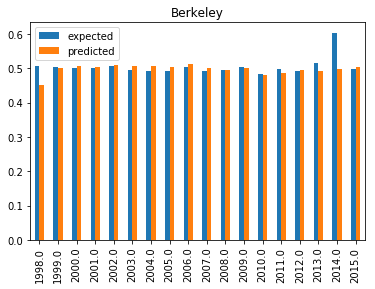

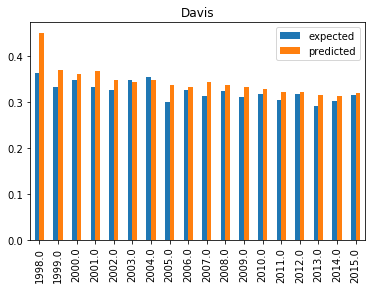

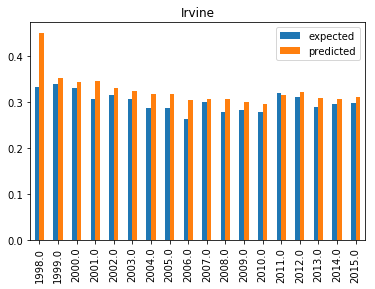

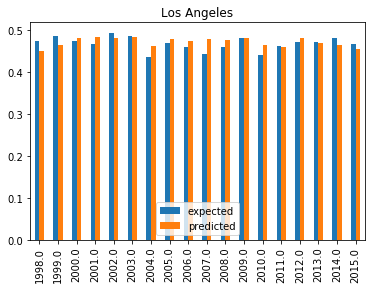

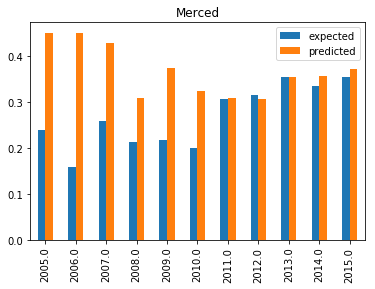

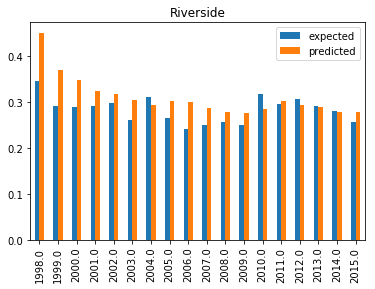

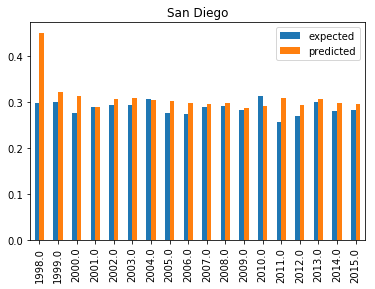

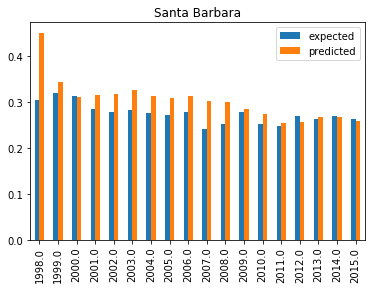

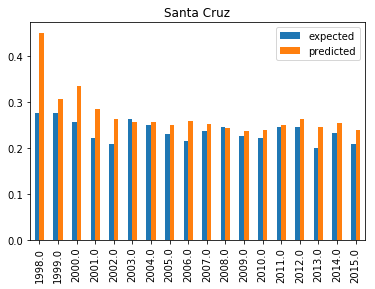

In [16]:
baseline_preds = {}
for campus in data['campus'].unique():
    campus_data = get_data_for_campus(data, campus)
    data_split = get_training_split(campus_data, .7)
    base_pred = baseline_pred(
        campus_data,
        campus_data['school_num'],
        campus_data['year']
    )
    
    yearly = predictions_to_yearly(campus_data, campus_data['school_num'], campus_data['year'], base_pred)
    result_matrix = pd.DataFrame(evaluate_yearly_predictions(yearly, get_year_yields(campus_data))).T
    display(campus, result_matrix)
    result_matrix[['expected','predicted']].plot(kind='bar', title=campus)
    baseline_preds[campus] = result_matrix

Now find the RMS error in our predictions. That is, for this baseline model, what can we expect to be the average error for a given campus in a year.

In [22]:
errors = np.concatenate([results['rms'].values for results in baseline_preds.values()])
rms_error = (errors**2).mean()**.5
print(rms_error)

97.97401329679283


In other words, for a given campus and year, the average RMS error is 98 students. Compared to the ~1000 students who do attend each UC school from this sample of California High School students, this means we have an error of about 10%.

## Preparing and fitting a linear regressor

### Choosing the model

We are performing a regression, so that means we should not use classification algorithms such as nearest neighbors, logistic regression, SVMs, or decision trees. Two remaining possibilities would have been to use linear regression or a neural network, but we don’t think this problem is complex enough to warrant the added difficulties, complications, and lack of interpretability that a neural network would add. Thus, we decided to use a simple linear regression model. It was a good choice because it was fast to run over our many different experiments that we performed, easy to understand how it behaved so we could better troubleshoot with our rapid development schedule, and descriptive enough to adequately predict the relatively simple problem we were tackling.

### Other possible models

- **Using wide datapoints** - one for each year. The datapoints would include the following features:
  - For each school:
      - Number of applied
      - Number of accepted
      - GPA of applied
      - GPA of accepted
      - SAT scores
      - AP scores
      - High school enrollment
      - High school distance from the UC campus
  - Year
  
 We decided against using that model. One of the main reasons was insufficient time to experiment with combined features (we believe that we should multiply each feature but the number of accepted students).

- **Wide datapoints with random sampling.** - as above, but we would generate random datapoints where only sum of the high schools will be set. This way, we can overcome one of the most significant problems of the model above - an extremely small number of datapoints.

- Using this method above, we should be able to create enough data points for running a Neural Net
  


In [23]:
from sklearn.linear_model import LinearRegression

def prepare_linear_reg_model(data_split):
    reg = LinearRegression()
    reg.fit(data_split['z_inputs_training_set'], data_split['z_outputs_training_set'])    
    return reg

def evaluate_linear_reg_model(reg, data_split):
    y_pred = reg.predict(data_split['z_inputs_test_set'])
    eval_result = pd.DataFrame(data={
        'z-actual':data_split['z_outputs_test_set'].values.flatten(),
        'z-predicted':y_pred.flatten(),
        'school_num': data_split['original']['school_num'][data_split['test_filter']].values.flatten(),
        'year': data_split['original']['year'][data_split['test_filter']].values.flatten(),
        'predicted': undo_z_score(y_pred.flatten(), data_split['outputs_training_set']['yield'])
    })
    return eval_result

def extract_yearly_predictions(d_split, eval_results):
    yearly = predictions_to_yearly(
        d_split['original'],
        eval_results['school_num'],
        eval_results['year'],
        eval_results['predicted']
    )
    yearly_eval_res = evaluate_yearly_predictions(yearly, get_year_yields(d_split['original']))
    return pd.DataFrame(yearly_eval_res).T

'Berkeley'

,predicted,school_num,year,z-actual,z-predicted
0,0.587233,3833241.0,2012.0,-0.839239,0.237275
1,0.761656,3833241.0,2012.0,1.891815,1.240132
2,0.681733,3833241.0,2012.0,0.519754,0.780610
3,0.600090,730283.0,2012.0,0.693984,0.311196
4,0.486626,1930080.0,2012.0,0.885637,-0.341173
5,0.530490,130229.0,2012.0,-0.139290,-0.088975
6,0.602246,130450.0,2012.0,0.258409,0.323591
7,0.558869,1933852.0,2012.0,0.454418,0.074194
8,0.786390,2730109.0,2012.0,1.565134,1.382345
9,0.410346,3030574.0,2012.0,-1.323415,-0.779755


'Berkeley'

,adm,expected,predicted,predicted_enr,rms
2012.0,1340.0,0.492526,0.520474,697.434881,37.449829
2013.0,1282.0,0.516706,0.522148,669.393187,6.976714
2014.0,1625.0,0.603924,0.517980,841.717624,139.658833
2015.0,1847.0,0.498636,0.506094,934.756374,13.775469


Regressor score for Berkeley 0.2632495248587695


'Davis'

,predicted,school_num,year,z-actual,z-predicted
0,0.410493,3833241.0,2012.0,1.227991,0.303350
1,0.314595,730283.0,2012.0,-0.429180,-0.353656
2,0.342509,4338802.0,2012.0,-1.299964,-0.162415
3,0.199126,1930080.0,2012.0,-1.075030,-1.144749
4,0.242217,130229.0,2012.0,-0.017668,-0.849527
5,0.333428,130450.0,2012.0,-0.653473,-0.224632
6,0.275732,1930163.0,2012.0,0.325962,-0.619914
7,0.503354,2730109.0,2012.0,0.015113,0.939555
8,0.187164,3030574.0,2012.0,-1.403966,-1.226700
9,0.301677,130583.0,2012.0,-0.940656,-0.442158


'Davis'

,adm,expected,predicted,predicted_enr,rms
2012.0,4520.0,0.315927,0.290744,1314.164869,113.827266
2013.0,4207.0,0.291305,0.296175,1246.008511,20.486833
2014.0,3913.0,0.300551,0.291425,1140.345041,35.709263
2015.0,3574.0,0.315481,0.312161,1115.663389,11.866318


Regressor score for Davis 0.3456308119639272


'Irvine'

,predicted,school_num,year,z-actual,z-predicted
0,0.346871,3833241.0,2012.0,-0.305537,0.229957
1,0.275948,3833241.0,2012.0,-0.363790,-0.355956
2,0.308974,5631619.0,2012.0,0.224035,-0.083116
3,0.200060,130229.0,2012.0,-1.430879,-0.982896
4,0.307890,1933852.0,2012.0,0.019772,-0.092071
5,0.296011,1930163.0,2012.0,0.442095,-0.190211
6,0.316277,3030574.0,2012.0,0.668876,-0.022784
7,0.211917,130062.0,2012.0,-1.295981,-0.884939
8,0.412066,3030228.0,2012.0,1.712413,0.768554
9,0.499082,111583.0,2012.0,2.527675,1.487423


'Irvine'

,adm,expected,predicted,predicted_enr,rms
2012.0,4540.0,0.309784,0.310616,1410.196780,3.778238
2013.0,4824.0,0.288346,0.305062,1471.617241,80.635664
2014.0,4551.0,0.294779,0.307558,1399.698116,58.160773
2015.0,4281.0,0.296444,0.315592,1351.049887,81.974781


Regressor score for Irvine 0.11326389713627627


'Los Angeles'

,predicted,school_num,year,z-actual,z-predicted
0,0.577525,3833241.0,2012.0,0.807755,0.369489
1,0.510710,3833241.0,2012.0,0.207890,-0.022780
2,0.548072,5631619.0,2012.0,-0.085661,0.196570
3,0.503554,1930080.0,2012.0,0.794992,-0.064796
4,0.352974,130229.0,2012.0,-0.776370,-0.948852
5,0.430993,130450.0,2012.0,-0.949047,-0.490801
6,0.570815,1933852.0,2012.0,-0.574913,0.330095
7,0.552540,1930163.0,2012.0,0.501441,0.222804
8,0.492080,3030574.0,2012.0,0.041970,-0.132158
9,0.349289,130583.0,2012.0,-1.972775,-0.970488


'Los Angeles'

,adm,expected,predicted,predicted_enr,rms
2012.0,2224.0,0.471071,0.480980,1069.698510,22.037463
2013.0,2044.0,0.470531,0.482079,985.369109,23.603888
2014.0,2185.0,0.479167,0.483135,1055.650333,8.671166
2015.0,2011.0,0.465058,0.478321,961.902879,26.671607


Regressor score for Los Angeles 0.39647598116930266


'Merced'

,predicted,school_num,year,z-actual,z-predicted
0,0.342748,130229.0,2014.0,-0.888507,0.100122
1,0.381449,4332995.0,2014.0,1.086797,0.342949
2,0.473969,122721.0,2014.0,0.563922,0.923464
3,0.486469,2430601.0,2014.0,0.710327,1.001896
4,0.434827,112508.0,2014.0,1.086797,0.677868
5,0.387268,2430205.0,2014.0,0.319914,0.379459
6,0.483572,5030879.0,2014.0,0.921678,0.983721
7,0.587093,2430114.0,2014.0,-0.205011,1.633262
8,0.198396,113118.0,2014.0,-1.458517,-0.805613
9,0.342910,1932441.0,2014.0,0.041047,0.101134


'Merced'

,adm,expected,predicted,predicted_enr,rms
2014.0,631.0,0.334390,0.375578,236.989836,25.989836
2015.0,673.0,0.355126,0.421692,283.798578,44.798578


Regressor score for Merced -0.18105367427682162


'Riverside'

,predicted,school_num,year,z-actual,z-predicted
0,0.346893,3833241.0,2012.0,-0.070564,0.343135
1,0.108156,130229.0,2012.0,-0.757233,-1.445229
2,0.304674,1933852.0,2012.0,-0.666434,0.026871
3,0.314630,1930163.0,2012.0,0.079417,0.101455
4,0.201152,3030574.0,2012.0,-0.142592,-0.748600
5,0.345725,3630225.0,2012.0,2.066274,0.334387
6,0.133020,130062.0,2012.0,-0.786609,-1.258979
7,0.373781,3030228.0,2012.0,-0.052204,0.544547
8,0.342811,3630423.0,2012.0,-0.052204,0.312552
9,0.239734,1930288.0,2012.0,-0.147704,-0.459587


'Riverside'

,adm,expected,predicted,predicted_enr,rms
2012.0,4364.0,0.306636,0.282873,1234.459378,103.700805
2013.0,4840.0,0.290383,0.282322,1366.437163,39.014750
2014.0,4991.0,0.280948,0.281450,1404.718021,2.508149
2015.0,5190.0,0.254995,0.283183,1469.718133,146.292824


Regressor score for Riverside 0.005677024252048413


'San Diego'

,predicted,school_num,year,z-actual,z-predicted
0,0.282436,5631619.0,2012.0,0.523971,-0.312362
1,0.273113,4338802.0,2012.0,0.914694,-0.382975
2,0.257799,1930080.0,2012.0,-0.768420,-0.498958
3,0.152469,130229.0,2012.0,-0.354115,-1.296735
4,0.233970,130450.0,2012.0,-0.936732,-0.679446
5,0.346739,1930163.0,2012.0,0.889942,0.174669
6,0.231048,3030574.0,2012.0,-1.008865,-0.701576
7,0.298683,130583.0,2012.0,-1.524104,-0.189306
8,0.220926,130062.0,2012.0,-0.419482,-0.778237
9,0.366783,4332995.0,2012.0,0.221647,0.326483


'San Diego'

,adm,expected,predicted,predicted_enr,rms
2012.0,3409.0,0.268133,0.265874,906.365494,7.700499
2013.0,3960.0,0.299361,0.272794,1080.263483,105.207781
2014.0,3554.0,0.279208,0.267283,949.924089,42.380861
2015.0,3568.0,0.283045,0.279430,997.007279,12.897908


Regressor score for San Diego 0.27708873011994706


'Santa Barbara'

,predicted,school_num,year,z-actual,z-predicted
0,0.212534,3030574.0,2012.0,-0.836408,-0.828797
1,0.307754,4830170.0,2012.0,-0.064311,-0.100607
2,0.400867,112045.0,2012.0,1.794441,0.611470
3,0.223945,102871.0,2012.0,-0.896324,-0.741532
4,0.365374,3830288.0,2012.0,-0.039155,0.340041
5,0.339535,3030434.0,2012.0,1.794441,0.142439
6,0.379746,3030855.0,2012.0,1.021972,0.449950
7,0.277982,730051.0,2012.0,2.412415,-0.328285
8,0.178959,106328.0,2012.0,-0.441652,-1.085555
9,0.392309,1530369.0,2012.0,1.369583,0.546027


'Santa Barbara'

,adm,expected,predicted,predicted_enr,rms
2012.0,2666.0,0.269663,0.252194,672.350277,46.571071
2013.0,2999.0,0.262479,0.228665,685.766536,101.407318
2014.0,2977.0,0.268857,0.236724,704.727714,95.659144
2015.0,2487.0,0.262545,0.235493,585.670851,67.278968


Regressor score for Santa Barbara 0.3223307522110961


'Santa Cruz'

,predicted,school_num,year,z-actual,z-predicted
0,0.338491,3833241.0,2012.0,1.670625,0.571547
1,0.324235,3833241.0,2012.0,-0.681934,0.449306
2,0.318343,3833241.0,2012.0,-0.107841,0.398785
3,0.228661,730283.0,2012.0,-0.646598,-0.370217
4,0.299052,4338802.0,2012.0,0.425245,0.233375
5,0.248206,1930080.0,2012.0,-1.134447,-0.202623
6,0.412433,118588.0,2012.0,0.695458,1.205588
7,0.210583,130229.0,2012.0,-0.787469,-0.525224
8,0.270090,130450.0,2012.0,0.034524,-0.014972
9,0.253715,1933852.0,2012.0,-0.556838,-0.155385


'Santa Cruz'

,adm,expected,predicted,predicted_enr,rms
2012.0,3162.0,0.245765,0.255854,809.010768,31.900820
2013.0,2730.0,0.198804,0.240942,657.770821,115.035395
2014.0,3613.0,0.232022,0.247611,894.619467,56.322276
2015.0,3168.0,0.207386,0.237678,752.963287,95.963287


Regressor score for Santa Cruz 0.372735432755769


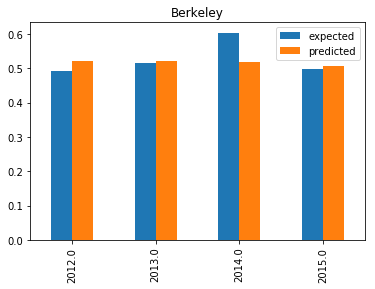

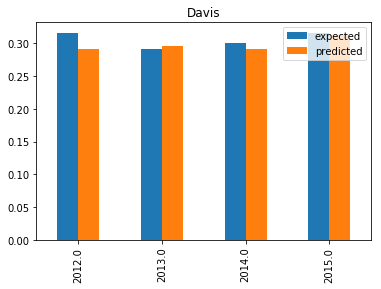

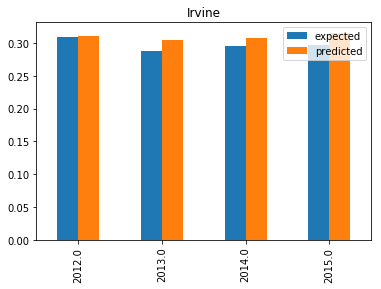

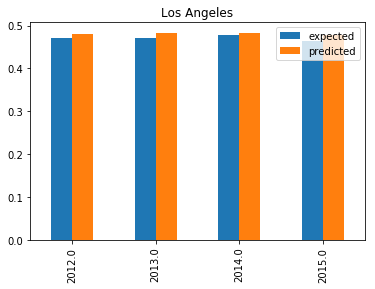

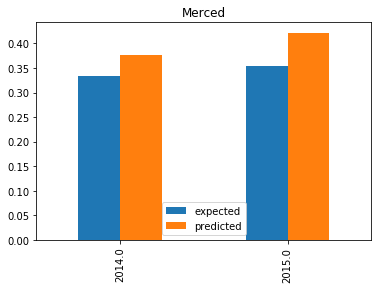

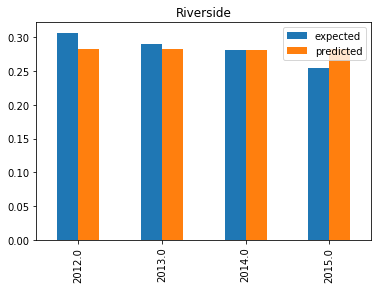

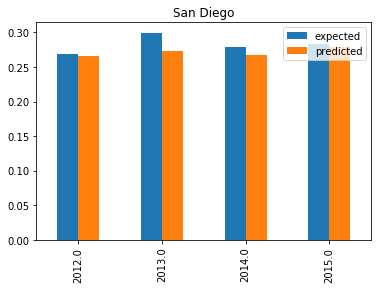

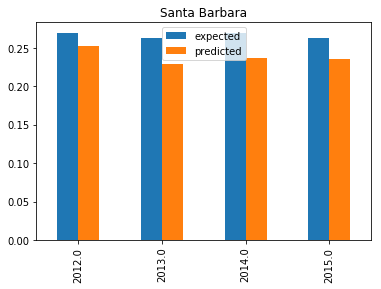

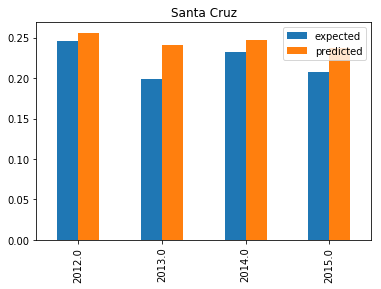

In [24]:
regressor_results = {}

for campus in data['campus'].unique():
    campus_resuts = {}
    regressor_results[campus] = campus_resuts
    
    d_split = get_training_split(get_data_for_campus(data, campus), .7)
    
    model = prepare_linear_reg_model(d_split)
    per_school_results = evaluate_linear_reg_model(model, d_split)
    display(campus, per_school_results)
    campus_resuts['per_school'] = per_school_results
    
    yearly_pred_eval = extract_yearly_predictions(d_split, per_school_results)
    campus_resuts['yearly'] = yearly_pred_eval
    display(campus, yearly_pred_eval)
    yearly_pred_eval[['expected', 'predicted']].plot.bar(title=campus)
    
    print('Regressor score for', campus, model.score(
        data_split['z_inputs_test_set'], data_split['z_outputs_test_set']
    ))


Now find the RMS error in our predictions. That is, for this linear regressor model, what can we expect to be the average error for a given campus in a year.

In [27]:
errors = np.concatenate([results['yearly']['rms'].values for results in regressor_results.values()])
rms_error = (errors**2).mean()**.5
print(rms_error)

67.86757326416893


Thus, on average for a single campus in a given year, our model misses the correct number of students by 68 students. This is about 1/3 better than our baseline model, which had an rms error of about 100 students. Compared to the ~1000 total students who attend each UC campus every year, this means our linear regressor has an average error of about 6%.

### Extra information on our regressor model

We will also use the `statsmodels` library to show more information about the performance of the linear regression model.


In [79]:
import statsmodels.api as sm

for campus in regressor_results:
    X_train2 = sm.add_constant(regressor_results[campus]['split']['z_inputs_training_set'])
    y_train = regressor_results[campus]['split']['z_outputs_training_set']
    est = sm.OLS(y_train, X_train2)
    est2 = est.fit()
    display(campus, est2.summary())

'Berkeley'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  yield   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     65.42
Date:                Tue, 15 May 2018   Prob (F-statistic):          1.74e-143
Time:                        09:30:50   Log-Likelihood:                -1344.1
No. Observations:                1203   AIC:                             2720.
Df Residuals:                    1187   BIC:                             2802.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3.917e-15      0.021   1.82e-13      1.000      -0.042       0.042
year                    0.0578      0.032      1.827      0.068      -0.004       0.120
app_num                 0.2188      0.066      3.338      0.001       0.090       0.347
adm_num                -0.3844      0.053     -7.303      0.000      -0.488      -0.281
app_gpa                 0.0003      0.034      0.008      0.994      -0.066       0.066
adm_gpa                -0.1077      0.030     -3.533      0.000      -0.167      -0.048
distance               -0.2897      0.026    -11.294      0.000      -0.340      -0.239
ap_num_scr1            -0.1358      0.046     -2.936      0.003      -0.226      -0.045
ap_num_scr2             0.1110      0.063      1.754      0.080      -0.013       0.235
ap_num_scr3             0.2372      0.104      2.280      0.023       0.033       0.441
ap_num_scr4            -0.3690      0.114     -3.249      0.001      -0.592      -0.146
ap_num_scr5             0.4190      0.075      5.557      0.000       0.271       0.567
ap_num_test_takers     -0.3599      0.109     -3.303      0.001      -0.574      -0.146
enroll12                0.0662      0.039      1.689      0.091      -0.011       0.143
sat_total_avg          -0.3379      0.037     -9.037      0.000      -0.411      -0.265
sat_num_test_takers    -0.0816      0.058     -1.409      0.159      -0.195       0.032
==============================================================================
Omnibus:                       25.457   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.604
Skew:                           0.346   Prob(JB):                     1.67e-06
Kurtosis:                       3.228   Cond. No.                         18.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Davis'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  yield   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     66.57
Date:                Tue, 15 May 2018   Prob (F-statistic):          5.88e-152
Time:                        09:30:50   Log-Likelihood:                -1645.2
No. Observations:                1429   AIC:                             3322.
Df Residuals:                    1413   BIC:                             3407.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5.707e-15      0.020   -2.8e-13      1.000      -0.040       0.040
year                    0.1333      0.029      4.637      0.000       0.077       0.190
app_num                 0.0236      0.077      0.306      0.760      -0.127       0.175
adm_num                -0.1746      0.068     -2.553      0.011      -0.309      -0.040
app_gpa                 0.0670      0.042      1.578      0.115      -0.016       0.150
adm_gpa                -0.1926      0.044     -4.389      0.000      -0.279      -0.107
distance               -0.2677      0.026    -10.217      0.000      -0.319      -0.216
ap_num_scr1            -0.1532      0.045     -3.435      0.001      -0.241      -0.066
ap_num_scr2             0.2748      0.063      4.369      0.000       0.151       0.398
ap_num_scr3            -0.2014      0.112     -1.804      0.071      -0.420       0.018
ap_num_scr4             0.0821      0.122      0.671      0.502      -0.158       0.322
ap_num_scr5             0.1751      0.078      2.245      0.025       0.022       0.328
ap_num_test_takers     -0.3358      0.115     -2.907      0.004      -0.562      -0.109
enroll12                0.0195      0.036      0.544      0.587      -0.051       0.090
sat_total_avg          -0.3124      0.035     -8.945      0.000      -0.381      -0.244
sat_num_test_takers    -0.0592      0.059     -1.002      0.317      -0.175       0.057
==============================================================================
Omnibus:                      184.722   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              312.539
Skew:                           0.852   Prob(JB):                     1.36e-68
Kurtosis:                       4.532   Cond. No.                         21.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Irvine'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  yield   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     46.11
Date:                Tue, 15 May 2018   Prob (F-statistic):          3.03e-110
Time:                        09:30:50   Log-Likelihood:                -1685.7
No. Observations:                1388   AIC:                             3403.
Df Residuals:                    1372   BIC:                             3487.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5.961e-15      0.022  -2.71e-13      1.000      -0.043       0.043
year                    0.0333      0.033      1.016      0.310      -0.031       0.098
app_num                 0.3757      0.104      3.609      0.000       0.171       0.580
adm_num                -0.2520      0.098     -2.582      0.010      -0.443      -0.061
app_gpa                 0.0836      0.043      1.928      0.054      -0.001       0.169
adm_gpa                -0.1247      0.044     -2.833      0.005      -0.211      -0.038
distance               -0.2652      0.025    -10.640      0.000      -0.314      -0.216
ap_num_scr1            -0.1341      0.046     -2.894      0.004      -0.225      -0.043
ap_num_scr2             0.0076      0.062      0.123      0.902      -0.114       0.129
ap_num_scr3             0.4050      0.102      3.976      0.000       0.205       0.605
ap_num_scr4            -0.1097      0.117     -0.938      0.349      -0.339       0.120
ap_num_scr5             0.1190      0.078      1.525      0.127      -0.034       0.272
ap_num_test_takers     -0.3546      0.104     -3.413      0.001      -0.559      -0.151
enroll12               -0.0244      0.036     -0.687      0.492      -0.094       0.045
sat_total_avg          -0.3818      0.039     -9.844      0.000      -0.458      -0.306
sat_num_test_takers    -0.2924      0.054     -5.424      0.000      -0.398      -0.187
==============================================================================
Omnibus:                       53.964   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.265
Skew:                           0.459   Prob(JB):                     4.97e-14
Kurtosis:                       3.465   Cond. No.                         18.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Los Angeles'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  yield   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     53.14
Date:                Tue, 15 May 2018   Prob (F-statistic):          7.95e-127
Time:                        09:30:50   Log-Likelihood:                -1805.5
No. Observations:                1500   AIC:                             3643.
Df Residuals:                    1484   BIC:                             3728.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 6.87e-16      0.021   3.28e-14      1.000      -0.041       0.041
year                    0.0627      0.029      2.176      0.030       0.006       0.119
app_num                 0.0527      0.066      0.799      0.424      -0.077       0.182
adm_num                -0.2366      0.054     -4.364      0.000      -0.343      -0.130
app_gpa                 0.0207      0.036      0.576      0.565      -0.050       0.091
adm_gpa                -0.1268      0.033     -3.836      0.000      -0.192      -0.062
distance               -0.1765      0.025     -7.017      0.000      -0.226      -0.127
ap_num_scr1            -0.0719      0.044     -1.624      0.105      -0.159       0.015
ap_num_scr2             0.0005      0.057      0.009      0.993      -0.111       0.112
ap_num_scr3             0.1138      0.098      1.167      0.243      -0.077       0.305
ap_num_scr4            -0.0604      0.108     -0.560      0.576      -0.272       0.151
ap_num_scr5             0.0594      0.071      0.838      0.402      -0.080       0.199
ap_num_test_takers     -0.0978      0.093     -1.056      0.291      -0.279       0.084
enroll12                0.1369      0.034      4.084      0.000       0.071       0.203
sat_total_avg          -0.3078      0.039     -7.813      0.000      -0.385      -0.231
sat_num_test_takers    -0.1757      0.051     -3.462      0.001      -0.275      -0.076
==============================================================================
Omnibus:                       22.045   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.716
Skew:                           0.301   Prob(JB):                     1.17e-05
Kurtosis:                       3.034   Cond. No.                         17.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Merced'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  yield   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     17.12
Date:                Tue, 15 May 2018   Prob (F-statistic):           1.21e-25
Time:                        09:30:50   Log-Likelihood:                -156.06
No. Observations:                 169   AIC:                             344.1
Df Residuals:                     153   BIC:                             394.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.207e-15      0.049  -2.45e-14      1.000      -0.097       0.097
year                    0.1229      0.065      1.901      0.059      -0.005       0.251
app_num                -0.0254      0.347     -0.073      0.942      -0.710       0.659
adm_num                -0.3918      0.369     -1.063      0.289      -1.120       0.336
app_gpa                -0.1156      0.158     -0.732      0.465      -0.428       0.197
adm_gpa                 0.2677      0.151      1.778      0.077      -0.030       0.565
distance               -0.1527      0.069     -2.215      0.028      -0.289      -0.016
ap_num_scr1             0.0636      0.104      0.611      0.542      -0.142       0.269
ap_num_scr2             0.0959      0.184      0.521      0.603      -0.268       0.459
ap_num_scr3            -0.0834      0.277     -0.301      0.764      -0.631       0.464
ap_num_scr4             0.3538      0.257      1.374      0.171      -0.155       0.863
ap_num_scr5             0.0243      0.177      0.137      0.891      -0.325       0.374
ap_num_test_takers     -0.2354      0.292     -0.807      0.421      -0.812       0.341
enroll12                0.0131      0.100      0.131      0.896      -0.184       0.210
sat_total_avg          -0.2169      0.097     -2.236      0.027      -0.409      -0.025
sat_num_test_takers    -0.2518      0.169     -1.490      0.138      -0.586       0.082
==============================================================================
Omnibus:                       28.055   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.567
Skew:                           0.939   Prob(JB):                     2.56e-09
Kurtosis:                       4.446   Cond. No.                         28.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Riverside'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  yield   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     40.60
Date:                Tue, 15 May 2018   Prob (F-statistic):           1.67e-96
Time:                        09:30:50   Log-Likelihood:                -1526.6
No. Observations:                1253   AIC:                             3085.
Df Residuals:                    1237   BIC:                             3167.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.099e-16      0.023   9.02e-15      1.000      -0.046       0.046
year                   -0.0071      0.028     -0.254      0.800      -0.062       0.048
app_num                 0.4599      0.234      1.969      0.049       0.002       0.918
adm_num                -0.4128      0.236     -1.750      0.080      -0.876       0.050
app_gpa                -0.0505      0.068     -0.745      0.457      -0.184       0.083
adm_gpa                 0.1143      0.062      1.833      0.067      -0.008       0.237
distance               -0.2239      0.027     -8.206      0.000      -0.277      -0.170
ap_num_scr1            -0.1198      0.047     -2.535      0.011      -0.213      -0.027
ap_num_scr2             0.0187      0.065      0.289      0.773      -0.108       0.146
ap_num_scr3            -0.0668      0.119     -0.559      0.576      -0.301       0.168
ap_num_scr4            -0.1956      0.137     -1.424      0.155      -0.465       0.074
ap_num_scr5             0.1300      0.090      1.447      0.148      -0.046       0.306
ap_num_test_takers      0.0143      0.112      0.127      0.899      -0.206       0.235
enroll12                0.0848      0.034      2.532      0.011       0.019       0.151
sat_total_avg          -0.2194      0.043     -5.098      0.000      -0.304      -0.135
sat_num_test_takers    -0.2142      0.057     -3.755      0.000      -0.326      -0.102
==============================================================================
Omnibus:                      151.620   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              247.418
Skew:                           0.817   Prob(JB):                     1.88e-54
Kurtosis:                       4.438   Cond. No.                         37.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'San Diego'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  yield   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     49.13
Date:                Tue, 15 May 2018   Prob (F-statistic):          2.63e-115
Time:                        09:30:50   Log-Likelihood:                -1570.0
No. Observations:                1315   AIC:                             3172.
Df Residuals:                    1299   BIC:                             3255.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -1.42e-14      0.022  -6.41e-13      1.000      -0.043       0.043
year                   -0.0507      0.030     -1.673      0.095      -0.110       0.009
app_num                 0.1628      0.097      1.673      0.095      -0.028       0.354
adm_num                -0.2655      0.082     -3.246      0.001      -0.426      -0.105
app_gpa                 0.1145      0.042      2.744      0.006       0.033       0.196
adm_gpa                -0.1549      0.039     -3.952      0.000      -0.232      -0.078
distance               -0.1229      0.026     -4.807      0.000      -0.173      -0.073
ap_num_scr1            -0.1873      0.049     -3.848      0.000      -0.283      -0.092
ap_num_scr2             0.0241      0.064      0.378      0.706      -0.101       0.149
ap_num_scr3             0.0325      0.105      0.309      0.757      -0.174       0.239
ap_num_scr4            -0.4600      0.116     -3.965      0.000      -0.688      -0.232
ap_num_scr5             0.3620      0.079      4.569      0.000       0.207       0.518
ap_num_test_takers      0.1835      0.111      1.659      0.097      -0.033       0.400
enroll12                0.0697      0.037      1.903      0.057      -0.002       0.142
sat_total_avg          -0.4041      0.040     -9.984      0.000      -0.484      -0.325
sat_num_test_takers    -0.2559      0.058     -4.432      0.000      -0.369      -0.143
==============================================================================
Omnibus:                       90.728   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.827
Skew:                           0.621   Prob(JB):                     1.16e-25
Kurtosis:                       3.742   Cond. No.                         18.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Santa Barbara'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  yield   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     47.17
Date:                Tue, 15 May 2018   Prob (F-statistic):          1.20e-103
Time:                        09:30:50   Log-Likelihood:                -1093.2
No. Observations:                 960   AIC:                             2218.
Df Residuals:                     944   BIC:                             2296.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.626e-15      0.025   6.61e-14      1.000      -0.048       0.048
year                    0.0277      0.033      0.838      0.402      -0.037       0.092
app_num                -0.0324      0.108     -0.299      0.765      -0.245       0.180
adm_num                -0.3497      0.094     -3.729      0.000      -0.534      -0.166
app_gpa                 0.2847      0.056      5.043      0.000       0.174       0.396
adm_gpa                -0.3030      0.053     -5.720      0.000      -0.407      -0.199
distance               -0.0406      0.029     -1.411      0.159      -0.097       0.016
ap_num_scr1            -0.2398      0.055     -4.374      0.000      -0.347      -0.132
ap_num_scr2             0.1486      0.071      2.097      0.036       0.010       0.288
ap_num_scr3            -0.1010      0.127     -0.792      0.429      -0.351       0.149
ap_num_scr4             0.0524      0.138      0.381      0.703      -0.217       0.322
ap_num_scr5            -0.0080      0.083     -0.097      0.923      -0.170       0.154
ap_num_test_takers      0.0222      0.127      0.175      0.861      -0.227       0.272
enroll12               -0.1071      0.041     -2.587      0.010      -0.188      -0.026
sat_total_avg          -0.2590      0.046     -5.665      0.000      -0.349      -0.169
sat_num_test_takers    -0.0368      0.066     -0.560      0.575      -0.166       0.092
==============================================================================
Omnibus:                      138.285   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              264.626
Skew:                           0.868   Prob(JB):                     3.45e-58
Kurtosis:                       4.899   Cond. No.                         19.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Santa Cruz'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  yield   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     32.74
Date:                Tue, 15 May 2018   Prob (F-statistic):           1.47e-75
Time:                        09:30:50   Log-Likelihood:                -1168.9
No. Observations:                 966   AIC:                             2370.
Df Residuals:                     950   BIC:                             2448.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -9.287e-15      0.026  -3.53e-13      1.000      -0.052       0.052
year                    0.0807      0.038      2.133      0.033       0.006       0.155
app_num                 0.3313      0.153      2.166      0.031       0.031       0.631
adm_num                -0.5407      0.147     -3.677      0.000      -0.829      -0.252
app_gpa                 0.1295      0.075      1.723      0.085      -0.018       0.277
adm_gpa                -0.1735      0.071     -2.461      0.014      -0.312      -0.035
distance               -0.0097      0.032     -0.300      0.764      -0.073       0.053
ap_num_scr1            -0.0735      0.059     -1.237      0.216      -0.190       0.043
ap_num_scr2             0.0825      0.082      1.011      0.312      -0.078       0.243
ap_num_scr3             0.0021      0.131      0.016      0.987      -0.256       0.260
ap_num_scr4            -0.3206      0.142     -2.258      0.024      -0.599      -0.042
ap_num_scr5             0.1871      0.095      1.973      0.049       0.001       0.373
ap_num_test_takers      0.0283      0.134      0.211      0.833      -0.235       0.291
enroll12                0.0555      0.051      1.089      0.276      -0.045       0.155
sat_total_avg          -0.1805      0.046     -3.924      0.000      -0.271      -0.090
sat_num_test_takers    -0.3104      0.073     -4.269      0.000      -0.453      -0.168
==============================================================================
Omnibus:                      265.293   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              874.319
Skew:                           1.320   Prob(JB):                    1.39e-190
Kurtosis:                       6.841   Cond. No.                         21.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Results
Both our baseline model and linear regression model suggested us that the yield rate would stay at around 45% - 50%, both of which are solid predictions. However, our linear regression model **did** perform better, with an average by-campus error of 68 students, as opposed to the 100 student error of the baseline model. For the ~1000 students who actually did enroll in each campus per year (from these California High Schools, obviously there are more than 1000 students total who start at each UC campus), these two numbers correspond to errors of about 6.8% and 10%, respectively. Thus, our linear model is significantly more useful than the baseline model, and the UC school system could benefit from using it.

The next interesting thing we can look at is our plots of actual vs predicted yield rates for our linear regressor:

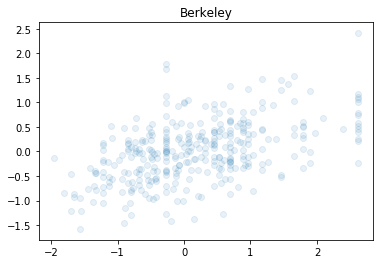

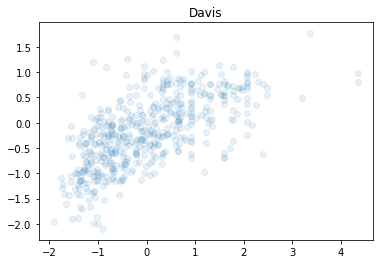

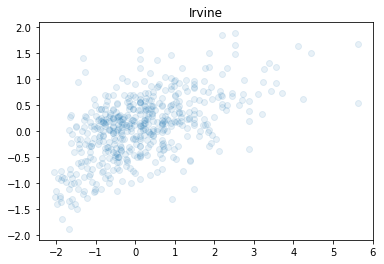

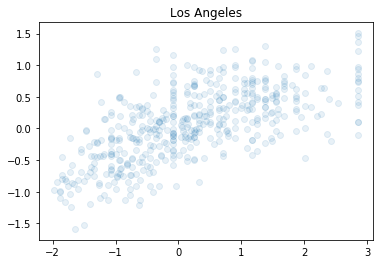

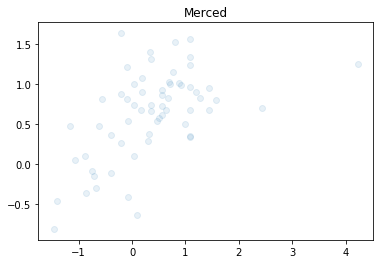

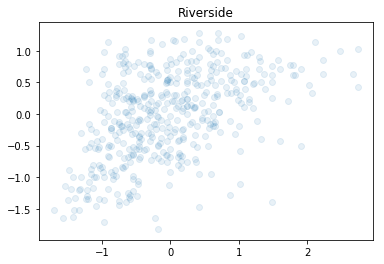

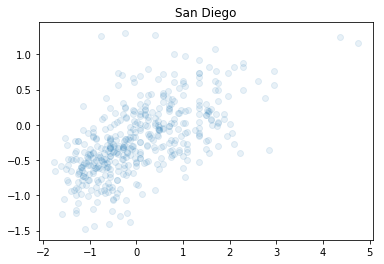

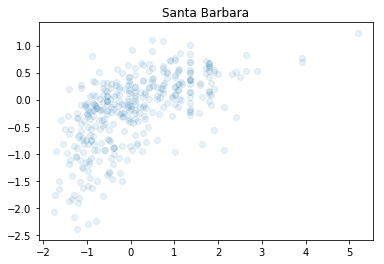

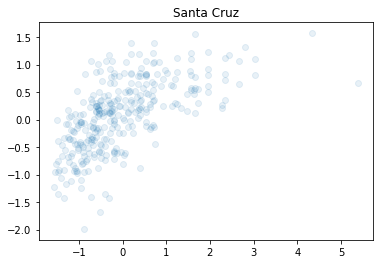

In [30]:
for campus in regressor_results:
    plt.scatter(
        regressor_results[campus]['per_school']['z-actual'].values.flatten(),
        regressor_results[campus]['per_school']['z-predicted'].values.flatten(),
        alpha=.1
    )
    plt.title(campus)
    plt.show()

In all of these plots we can see that the points follow a "hump" shape, which means that our model overpredicts for the middle yield rates and underpredicts for both the low and high yield rates. We are not sure what could be causing this error. Perhaps the yield rate is not actually linearly related to any of our features, and we should have transformed some of our features so that we are performing a quadratic fit or similar.